In [2]:
import pandas as pd
import numpy as np
from miceforest import ImputationKernel

import l0learn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

In [14]:
df_raw = pd.read_csv('../data/telecom_customer_churn.csv')
df_population = pd.read_csv('../data/telecom_zipcode_population.csv')

df = df_raw.copy()
df = df.query('`Customer Status` != "Joined"').reset_index(drop=True)

# join population by zip-code
df = pd.merge(left=df, right=df_population, on='Zip Code')

# remove unwanted columns
dropped_columns = ['Customer ID', 'Churn Category', 'Churn Reason', 'Latitude', 'Longitude', 'Zip Code']
df = df[[col for col in df.columns if col not in dropped_columns]]

# impute categoricals as NA
impute_na = ['Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 
             'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Multiple Lines']

df[impute_na] = df[impute_na].fillna('NA')
df['Offer'] = df['Offer'].fillna('No Offer')

# fix data types
categorical_columns = ['Gender', 'Married', 'City', 'Offer', 'Phone Service', 'Multiple Lines', 'Internet Service', 
                       'Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 
                       'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 
                       'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method',
                       'Customer Status']
df[categorical_columns] = df[categorical_columns].astype('category')

arranged_columns = list(df.columns[:-2])
arranged_columns.extend(['Population', 'Customer Status'])
df = df[arranged_columns]

df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], 
                                                                test_size=0.2, 
                                                                random_state=42)

rare_cities = df_X_train['City'].value_counts().index[df_X_train['City'].value_counts() <= 5]

df_X_train['City'] = df_X_train['City'].astype('object')
df_X_train.loc[df_X_train['City'].isin(rare_cities), 'City'] = 'Rare City'
df_X_train['City'] = df_X_train['City'].astype('category')

mice_kernel = ImputationKernel(
    data = df_X_train,
    save_all_iterations = True,
    random_state = 42
)

mice_kernel.mice(2)
mice_imputation = mice_kernel.complete_data()
mice_imputation.head()

df_X_train_imp = mice_imputation.copy()
df_X_train_imp_dummies = pd.get_dummies(df_X_train_imp, dtype='float')

y_train_numeric = df_y_train.map({'Stayed': 0, 'Churned': 1}).astype('float')

/home/vscode/.venv/lib/python3.10/site-packages/miceforest/ImputationKernel.py:370: UserWarning: [City] have very rare categories, it is a good idea to group these, or set the min_data_in_leaf parameter to prevent lightgbm from outputting 0.0 probabilities.
  warn(


In [95]:
user_lambda_grid = [[10, 5, 2, 1]]


In [102]:
cv_fit_result = l0learn.cvfit(df_X_train_imp_dummies.values, 
                              y_train_numeric.values, 
                              num_folds=5, 
                              seed=42, 
                              penalty="L0", 
                              loss='Logistic',
                              num_gamma=None, 
                              num_lambda=None,
                              max_support_size=30, 
                              lambda_grid=user_lambda_grid)

cv_fit_result.characteristics().join(pd.Series(cv_fit_result.cv_means[0].flatten(), name='Loss'))


,l0,support_size,intercept,converged,l2,Loss
0,10.0,13,-0.880785,True,1.000000e-07,0.346542
1,5.0,13,-0.879947,True,1.000000e-07,0.343604
2,2.0,20,-1.937278,True,1.000000e-07,0.340824
3,1.0,29,-1.717140,True,1.000000e-07,0.341704


In [103]:
best_fit = l0learn.fit(df_X_train_imp_dummies.values, 
                       y_train_numeric.values, 
                       penalty="L0", 
                       loss='Logistic', 
                       max_support_size=30, 
                       num_lambda=2)

/home/vscode/.venv/lib/python3.10/site-packages/l0learn/models.py:533: UserWarning: Duplicate solution seen at support size 13. Plotting only first solution
  warnings.warn(


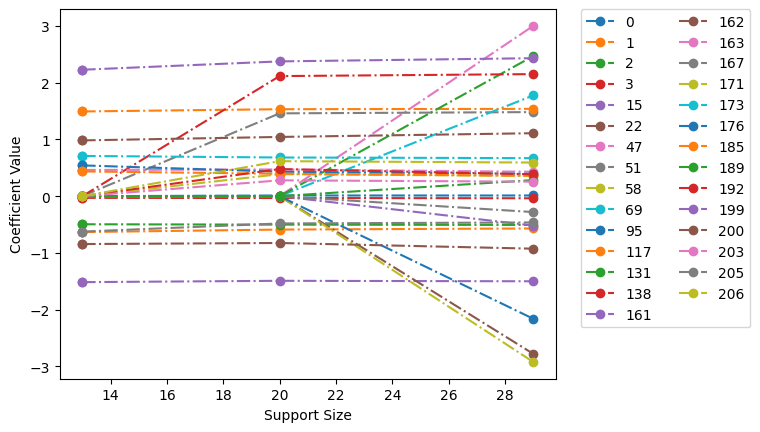

In [104]:
cv_fit_result.plot(show_lines=True);

In [105]:
all_solution_paths = [15, 1, 22, 173, 161, 200, 185, 189, 205, 0]
df_X_train_imp_dummies.columns[all_solution_paths]

Index(['Married_No', 'Number of Dependents', 'City_Bakersfield',
       'Internet Type_Fiber Optic', 'Offer_Offer C', 'Contract_One Year',
       'Premium Tech Support_No', 'Streaming TV_Yes',
       'Payment Method_Credit Card', 'Age'],
      dtype='object')

In [131]:
df_X_train_imp_dummies.shape
coeffs.shape

(208,)

In [128]:
coeffs = cv_fit_result.coeff(lambda_0=2.0).toarray().flatten()

for col, coeff in zip()

In [114]:
andbest_fit.coeffs

[<207x2 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>]